In [305]:
import numpy as np
import copy
import cv2
import random
from skimage.util.shape import view_as_windows
from matplotlib import pyplot as plt

(256, 256)
253.0


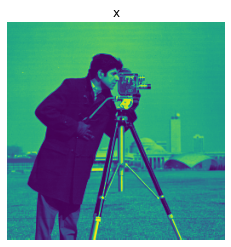

In [362]:
## 1.2 

x = cv2.imread('cameraman.tif', cv2.IMREAD_GRAYSCALE).astype('float')
print(x.shape)
print(x.max())
plt.imshow(x)
plt.title('x')
plt.axis('off')

N_1,N_2 = x.shape

def wm_estim_nb(v, x):
    return v-x

def correlation(wh, w):
    return np.dot(wh.flatten(),w.flatten())/np.sum(w!=0)

def add_wm(x, magn, density):
    """Returns the watermarked image
    x: original image
    magn: magnitude of the WM
    theta: density of the WM
    """
    wp = (2 * magn * np.random.randint(2, size=x.shape) - magn).astype(float)
    N_change = int(np.prod(wp.shape)*density)
    mask = [1]*N_change + [0]*(np.prod(wp.shape) - N_change)
    np.random.shuffle(mask)
    mask = np.reshape(mask, wp.shape)
    w = wp * mask
    return x+w, w

def add_attack(y, sigma): #v
    """Returns the attacked image
    y: input image
    sigma: std of the attack
    """
    z = sigma * np.random.randn(*(y.shape))
    return y+z

from skimage.util.shape import view_as_windows

def wm_estim_b(v, win_size=3): #return estimation of watermark by estimating the host image

    assert win_size>0, "the window size for the local averaging should be > 0"
    # pad original data in a symmetrical manner to have same output size as v
    xh = np.concatenate([v, v[:,-win_size+1:][:,::-1]], axis=1)
    xh = np.concatenate([xh, xh[-win_size+1:][::-1]], axis = 0)
    xh = view_as_windows(xh, (win_size, win_size))
    # local means
    xh = np.mean(xh.reshape([*v.shape, -1]), axis=-1)
    return v-xh

In [354]:
J = 100
sigma_noise = 50
density = 0.1
magn = 1


def computeMeanCorrH0(J,magn,density,sigma_noise):
    results = []
    for i in range(J):
        y, w = add_wm(x, magn, density)
        z = sigma_noise * np.random.randn(*(y.shape))
        v = x+z
        wh = v-x
        results.append(correlation(wh, w))
    return sum(results)/J

def computeVarCorrH0(J,magn,density,sigma_noise):
    mean = computeMeanCorrH0(J,magn,density,sigma_noise)
    results = []
    for i in range(J):
        results.append((computeMeanCorrH0(J,magn,density,sigma_noise)-mean)**2)
    
    return (sum(results)/J)


def computeCorrMeanH1(J,magn,density,sigma_noise):
    results = []
    for i in range(J):
        y, w = add_wm(x, magn, density)
        z = sigma_noise * np.random.randn(*(y.shape))
        v = x+z+w
        wh = v-x
        results.append(correlation(wh, w))

    return (sum(results)/J)


def computeVarCorrH1(J,magn,density,sigma_noise):
    mean = computeCorrMeanH1(J,magn,density,sigma_noise)
    results = []
    for i in range(J):
        results.append((computeCorrMeanH1(J,magn,density,sigma_noise)-mean)**2)
    
    return (sum(results)/J)



In [314]:
corrMeansH0 = []
corrMeansH1 = []
corrVarH0 = []
corrVarH1 = []

sigmas = [50,100]
magns = [1,5]
densities = [0.1,0.3]

In [315]:
for sigma in sigmas:
    corrMeansH0.append(computeMeanCorrH0(J,magn,density,sigma_noise))   
print(corrMeansH0)

[-0.2989363639285552, 0.028664748526998726]


In [316]:
for sigma in sigmas:
    corrVarH0.append(computeVarCorrH0(J,magn,density,sigma_noise))
print(corrVarH0)

[0.03911844849178052, 0.09086243321866858]


In [317]:
for sigma in sigmas:
    for density in densities:
        for magn in magns:
            corrMeansH1.append(computeCorrMeanH1(J,magn,density,sigma))
print(corrMeansH1)

[1.0747597979719823, 24.796720809487738, 1.0235113346170848, 25.281135221324515, 1.0995551113481257, 26.672541361855806, 1.0332084445800682, 25.150273673034327]


In [318]:
for sigma in sigmas:
    for density in densities:
        for magn in magns:
            corrVarH1.append(computeVarCorrH1(J,magn,density,sigma))
print(corrVarH1)

[0.004111481511377981, 0.10441767952341272, 0.0020014285765334113, 0.04320275039311974, 0.019596723411852646, 0.3993774698406968, 0.005140335944039851, 0.8598562272121052]


In [359]:
def plots(sigma,density,magn,J):

  H0 = []
  H1 = []

  for i in range(J):
        
    y, w = add_wm(x, magn, density)
    
    vH1 = add_attack(y, sigma)
    vH0 = add_attack(x, sigma)

    wh_H0 = wm_estim_nb(vH0, x) 
    wh_H1 = wm_estim_nb(vH1, x)

    
    H0.append(correlation(wh_H0, w))
    H1.append(correlation(wh_H1, w))


  results = H0 + H1

  tau = np.linspace(min(results),max(results),100)

  p_d = []
  p_f = []
  p_m = []
  # classfication #If corr < tau -> no watermark, if corr > tau -> watermark
    
  for t in tau: # We want to detect if there is w so if it comes from H1
    pf = 0
    pm = 0
    for corr_h0 in H0:
      if corr_h0 > t:  # telling that if corr_h0 > tau we are predicting that there is a watermark but there is not
          pf += 1
    
    for corr_h1 in H1:  # telling that if corr_h1 > tau we are predicting that there is no watermark but there is
      if corr_h1 < t:
        pm += 1

    p_m.append(pm/J)
    p_f.append(pf/J)
    p_d.append(1 - (pm/J)  )

  plt.figure()
  plt.plot(tau,p_m,label="$p_m$")
  plt.plot(tau,p_f,label="$p_f$")
  plt.plot(tau,p_d,label="$p_d$")
  plt.xlabel(r"$Tau$")
  plt.ylabel("probability")
  plt.legend()
  plt.grid()
  plt.title("$\sigma$ : "+str(sigma)+r"  $\theta_N$ : "+str(density)+r"  $\gamma : \pm$"+str(magn))
  plt.show()

  plt.figure()
  plt.plot(p_f,p_m,label="ROC")
  plt.xlabel("$p_f$")
  plt.ylabel("$p_m$")
  plt.legend()
  plt.grid()
  plt.title("$\sigma$ : "+str(sigma)+r"  $\theta_N$ : "+str(density)+r"  $\gamma : \pm$"+str(magn))
  plt.show()  

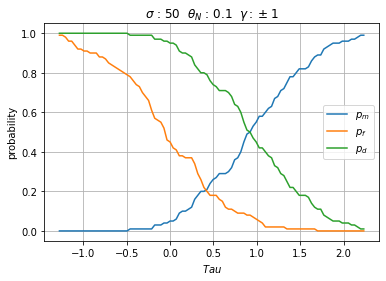

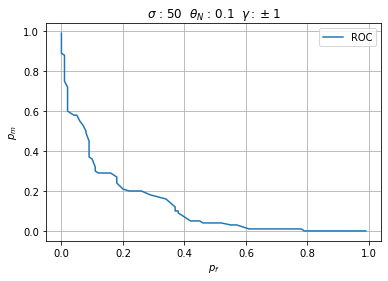

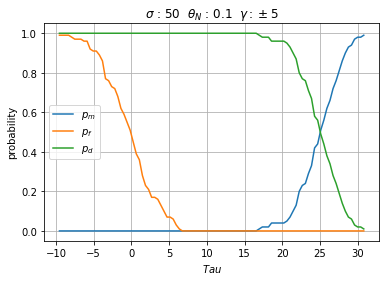

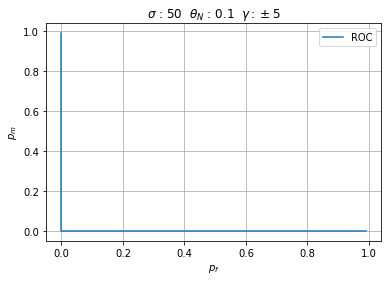

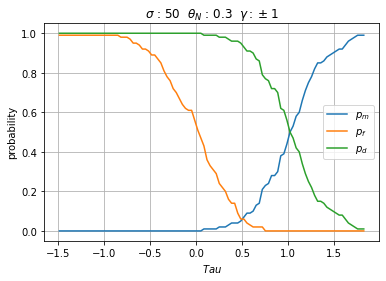

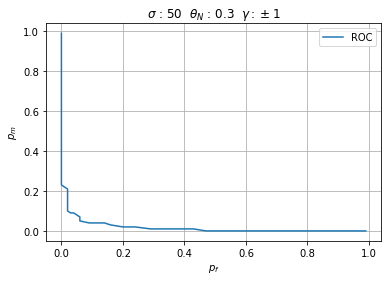

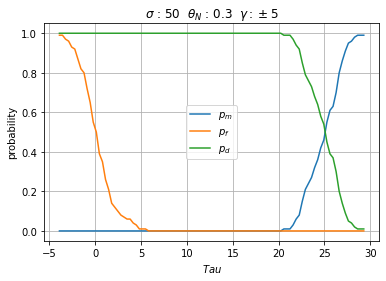

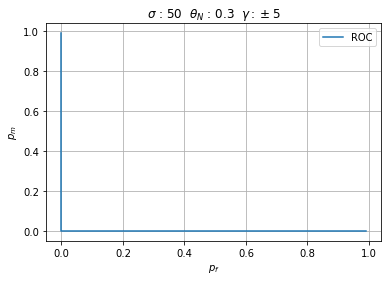

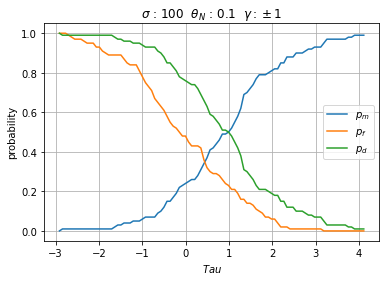

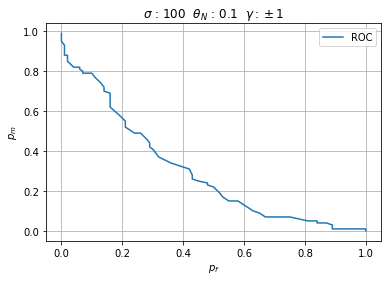

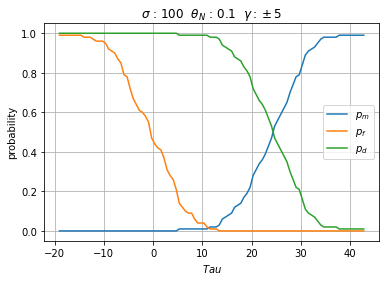

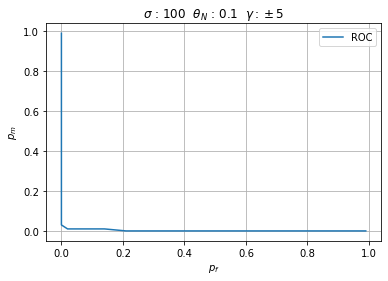

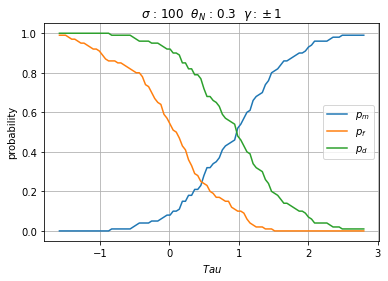

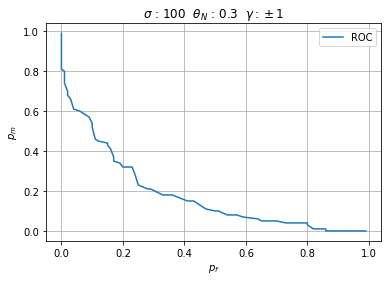

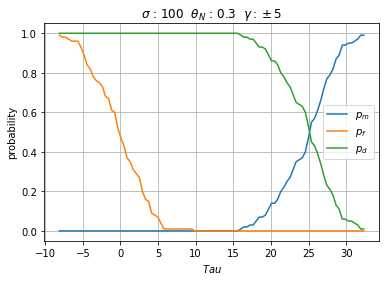

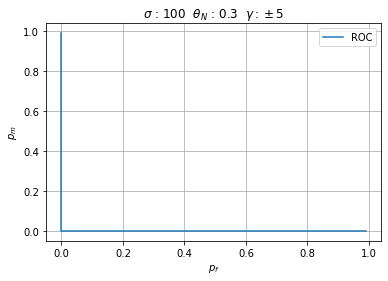

In [360]:
# Plot Curves pm,pf,pd and ROC

# parameters
sigmas = [50,100]
densities = [0.1,0.3]
magns = [1,5]
J = 100

for sigma in sigmas:
  for density in densities:
    for magn in magns:
      plots(sigma,density,magn,J)

In [363]:
#Blind watermark

def computeMeanCorrH0(J,magn,density,sigma_noise):
    results = []
    for i in range(J):
        y, w = add_wm(x, magn, density)
        z = sigma_noise * np.random.randn(*(y.shape))
        v = x+z
        wh = wm_estim_b(v)
        results.append(correlation(wh, w))
        
    return sum(results)/J

def computeVarCorrH0(J,magn,density,sigma_noise):
    mean = computeMeanCorrH0(J,magn,density,sigma_noise)
    results = []
    for i in range(J):
        results.append((computeMeanCorrH0(J,magn,density,sigma_noise)-mean)**2)
    
    return (sum(results)/J)


def computeCorrMeanH1(J,magn,density,sigma_noise):
    results = []
    for i in range(J):
        y, w = add_wm(x, magn, density)
        z = sigma_noise * np.random.randn(*(y.shape))
        v = x+z+w
        wh = wm_estim_b(v)
        results.append(correlation(wh, w))

    return (sum(results)/J)


def computeVarCorrH1(J,magn,density,sigma_noise):
    mean = computeCorrMeanH1(J,magn,density,sigma_noise)
    results = []
    for i in range(J):
        results.append((computeCorrMeanH1(J,magn,density,sigma_noise)-mean)**2)
    
    return (sum(results)/J)



In [365]:
corrMeansH0 = []
corrMeansH1 = []
corrVarH0 = []
corrVarH1 = []

J=100
sigmas = [50,100]
magns = [1,5]
densities = [0.1,0.3]

In [366]:
for sigma in sigmas:
    corrMeansH0.append(computeMeanCorrH0(J,magn,density,sigma_noise))   
print(corrMeansH0)

[0.13303306152155916, 0.05805174813192998]


In [367]:
for sigma in sigmas:
    corrVarH0.append(computeVarCorrH0(J,magn,density,sigma_noise))
print(corrVarH0)

[0.05439767971462919, 0.036565209147033394]


In [368]:
for sigma in sigmas:
    for density in densities:
        for magn in magns:
            corrMeansH1.append(computeCorrMeanH1(J,magn,density,sigma))
print(corrMeansH1)

[0.859456405765818, 22.635251548558003, 0.8954715230905295, 21.995400226325117, 0.8825849492995762, 23.075713424237296, 0.8541302387083305, 22.10241429067009]


In [369]:
for sigma in sigmas:
    for density in densities:
        for magn in magns:
            corrVarH1.append(computeVarCorrH1(J,magn,density,sigma))
print(corrVarH1)

[0.006723372636947517, 0.15996511872525684, 0.001416353374200069, 0.031006708020287762, 0.017837145410430168, 1.2405713232526234, 0.01967249264830043, 0.106810709314286]


In [370]:
def plots(sigma,density,magn,J):

  H0 = []
  H1 = []

  for i in range(J):
        
    y, w = add_wm(x, magn, density)
    
    vH1 = add_attack(y, sigma)
    vH0 = add_attack(x, sigma)

    wh_H0 = wm_estim_b(vH0)
    wh_H1 = wm_estim_b(vH1)

    
    H0.append(correlation(wh_H0, w))
    H1.append(correlation(wh_H1, w))


  results = H0 + H1

  tau = np.linspace(min(results),max(results),100)

  p_d = []
  p_f = []
  p_m = []
  # classfication #If corr < tau -> no watermark, if corr > tau -> watermark
    
  for t in tau: # We want to detect if there is w so if it comes from H1
    pf = 0
    pm = 0
    for corr_h0 in H0:
      if corr_h0 > t:  # telling that if corr_h0 > tau we are predicting that there is a watermark but there is not
          pf += 1
    
    for corr_h1 in H1:  # telling that if corr_h1 > tau we are predicting that there is no watermark but there is
      if corr_h1 < t:
        pm += 1

    p_m.append(pm/J)
    p_f.append(pf/J)
    p_d.append(1 - (pm/J)  )

  plt.figure()
  plt.plot(tau,p_m,label="$p_m$")
  plt.plot(tau,p_f,label="$p_f$")
  plt.plot(tau,p_d,label="$p_d$")
  plt.xlabel(r"$Tau$")
  plt.ylabel("probability")
  plt.legend()
  plt.grid()
  plt.title("$\sigma$ : "+str(sigma)+r"  $\theta_N$ : "+str(density)+r"  $\gamma : \pm$"+str(magn))
  plt.show()

  plt.figure()
  plt.plot(p_f,p_m,label="ROC")
  plt.xlabel("$p_f$")
  plt.ylabel("$p_m$")
  plt.legend()
  plt.grid()
  plt.title("$\sigma$ : "+str(sigma)+r"  $\theta_N$ : "+str(density)+r"  $\gamma : \pm$"+str(magn))
  plt.show()  

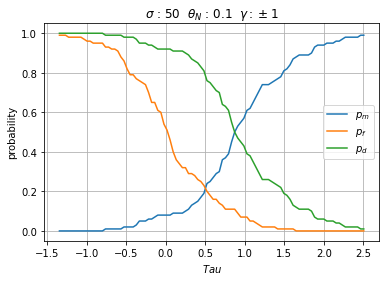

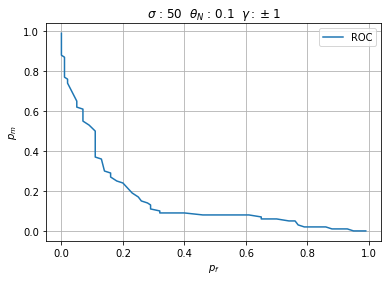

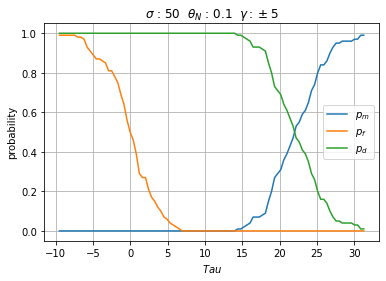

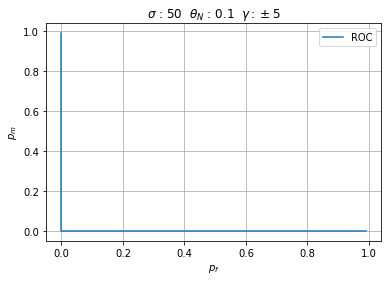

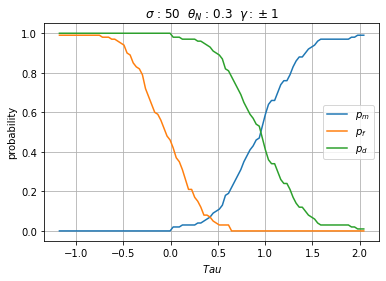

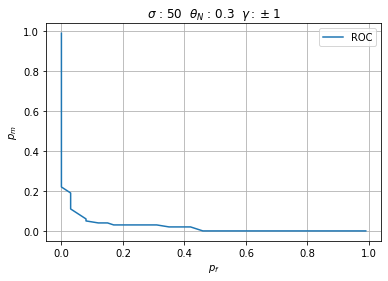

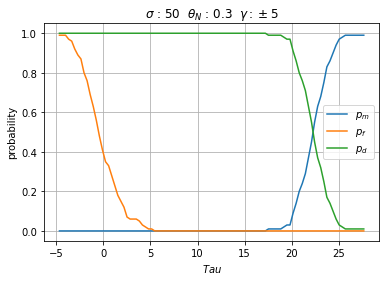

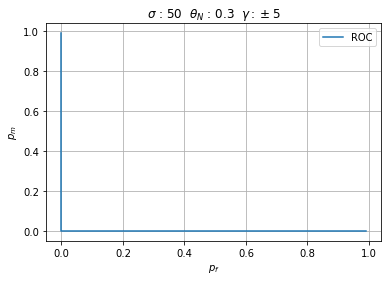

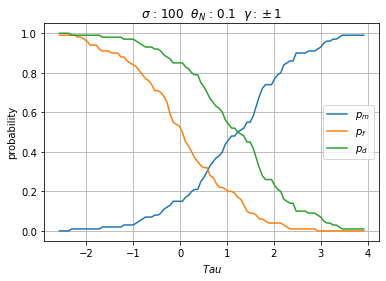

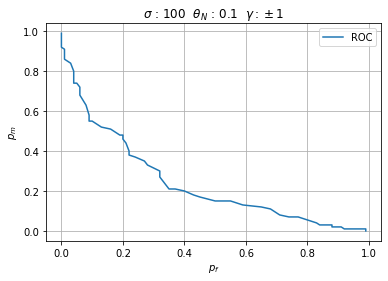

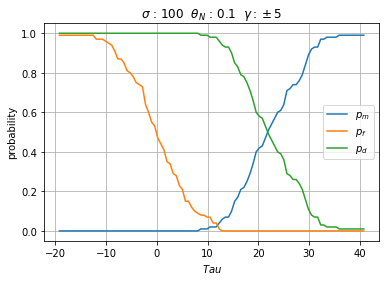

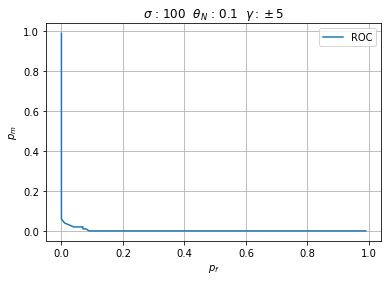

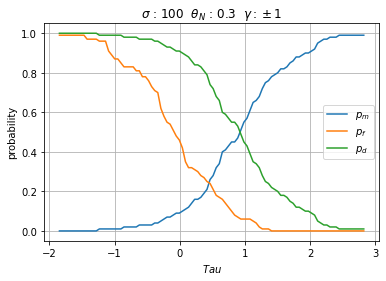

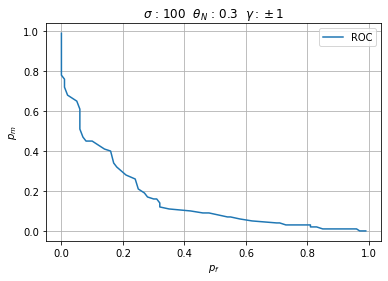

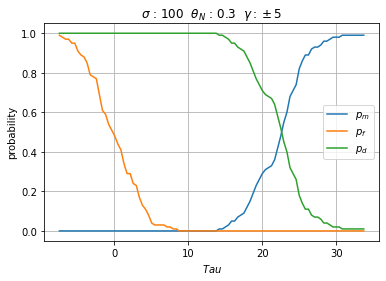

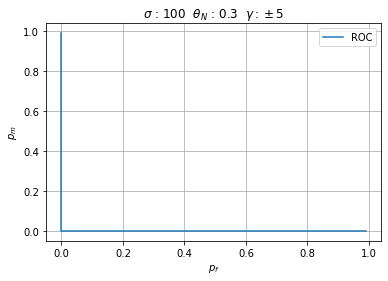

In [371]:
# Plot Curves pm,pf,pd and ROC

# parameters
sigmas = [50,100]
densities = [0.1,0.3]
magns = [1,5]
J = 100

for sigma in sigmas:
  for density in densities:
    for magn in magns:
      plots(sigma,density,magn,J)